# Tutorial 3: Mouse Brain dataset

In this tutorial, we demonstrate how to use S3RL to analyze the Mouse Brain Anterior dataset from 10X Genomics. This dataset captures anterior brain structures and is commonly used for evaluating spatial clustering performance.

The dataset can be downloaded from the 10X Genomics resource portal (https://mouse.brain-map.org/static/atlas), including spatial gene expression matrices and histology images.

We applied S3RL on the H&E image, gene expression, and spatial coordinates to identify anatomical domains. The model successfully highlights biologically distinct regions such as the glomerular and mitral layers, supported by spatial marker genes like Gabra1 and Penk.

#### Prepare data

In [ ]:
import scanpy as sc
import os
import cv2
from S3RL.process_data import process_data
import pandas as pd
import numpy as np

path = '../Data'
dataset = 'Mouse_Brain_Anterior'
id = '' 
knn = 5
pixel_size = 10
path_semantic_fea = '../Img_encoder/models/'

adata = sc.read_h5ad(os.path.join(path, dataset, id, 'sampledata.h5ad'))
adata.var_names_make_unique()

sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000, check_values=False)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Ann_df = pd.read_csv(os.path.join(path, dataset, id, 'annotation.txt'), sep='\t', header=None, index_col=0)
Ann_df.columns = ['Ground Truth']
drop = Ann_df.loc[adata.obs_names, 'Ground Truth'].isna()
adata = adata[~drop]
adata = adata[:, adata.var['highly_variable']]

image = cv2.imread(os.path.join(path, dataset, id, 'spatial/tissue_hires_image.png'))
semantic_fea = np.load(os.path.join(path_semantic_fea, dataset, id, 'img_emb.npy'))

adata = process_data(adata, image, pixel=pixel_size, knn=knn, semantic_fea=semantic_fea)

#### Train model

In [2]:
from S3RL.model import S3RL
import yaml
import torch
from sklearn.metrics import adjusted_rand_score

device = torch.device("cuda:0")
C = len(set(Ann_df[Ann_df['Ground Truth'].notna()]['Ground Truth'].values.tolist()))
cfg_path = './Best_cfg'
with open(os.path.join(cfg_path, dataset, dataset+'.yaml'), 'r') as f:
    cfg = yaml.safe_load(f)

model = S3RL(adata, n_clu=C, device=device, **cfg)

adata = model.train()

Training the S3RL model:  88%|████████▊ | 4400/5000 [02:33<00:20, 28.65it/s]


Reached the tolerance, early stop training at epoch 4400


In [3]:
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']
ground_truth = adata.obs['Ground Truth'].astype('category').cat.codes.values
print('ARI is', adjusted_rand_score(ground_truth, adata.obs['pred']))

ARI is 0.5096722891630927


#### Visualization

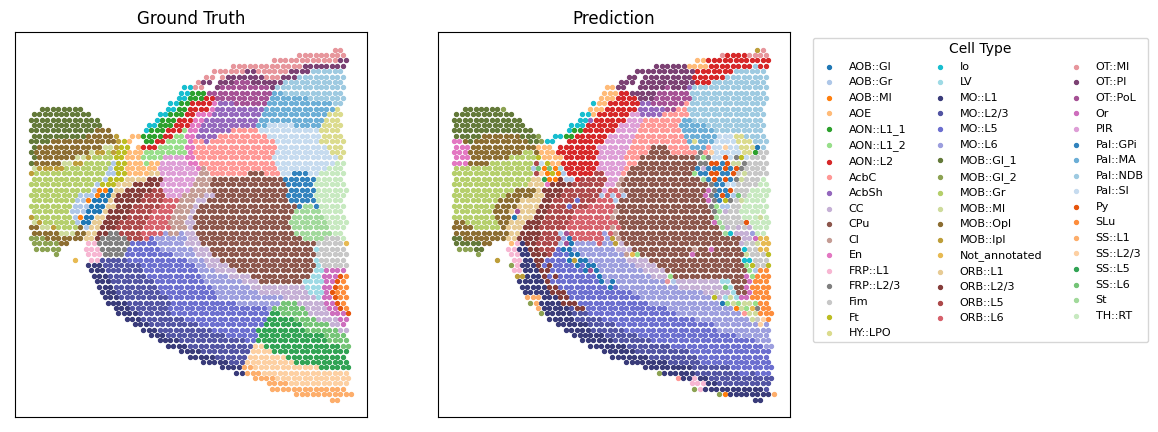

In [4]:
import matplotlib
from S3RL.tools import hungarian_match
import numpy as np
import matplotlib.pyplot as plt

label_pred = hungarian_match(ground_truth, adata.obs['pred'])
label_dict = dict(zip(ground_truth, adata.obs['Ground Truth'].values))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

colors = np.vstack([np.array(matplotlib.colormaps['tab20'].colors), 
                    np.array(matplotlib.colormaps['tab20b'].colors), 
                    np.array(matplotlib.colormaps['tab20c'].colors)])

for i in set(ground_truth):
    axs[0].scatter(adata.obsm['spatial'][ground_truth==i, 0], adata.obsm['spatial'][ground_truth==i, 1], color=colors[i], s=8)
    axs[1].scatter(adata.obsm['spatial'][label_pred==i, 0], adata.obsm['spatial'][label_pred==i, 1], color=colors[i], s=8, label=label_dict[i])

axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, title='Cell Type', title_fontsize=10, ncol=3)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

axs[0].set_title('Ground Truth')
axs[1].set_title('Prediction')

plt.show()